<h2>Получение данных</h2>

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Создаем синтетический датасет
np.random.seed(42)
n_samples = 1500

data = {
    # Факторы
    'f0': np.concatenate([
        np.random.normal(220, 40, n_samples//2),  # гласные 
        np.random.normal(40, 20, n_samples//2)   # сонанты
    ]),
    'f1': np.concatenate([
        np.random.normal(600, 150, n_samples//2),  
        np.random.normal(100, 100, n_samples//2)  
    ]),
    'f2': np.concatenate([
        np.random.normal(1500, 300, n_samples//2), 
        np.random.normal(2800, 200, n_samples//2)  
    ]),
    'intensity': np.concatenate([
        np.random.normal(75, 8, n_samples//2),     
        np.random.normal(25, 12, n_samples//2)     
    ]),
    'duration': np.concatenate([
        np.random.normal(150, 30, n_samples//2),   
        np.random.normal(40, 15, n_samples//2)     
    ]),
    'spectral_centroid': np.concatenate([
        np.random.normal(600, 100, n_samples//2), 
        np.random.normal(2200, 200, n_samples//2) 
    ]),
}

# Задаем тип (0-сонант, 1-гласный)
sound_type = np.concatenate([np.ones(n_samples//2), np.zeros(n_samples//2)])

# Добавляем шум и перемешиваем
np.random.shuffle(sound_type)
for key in data:
    data[key] = data[key] + np.random.normal(0, 10, n_samples)

# Создаем DataFrame
df = pd.DataFrame(data)
df['sound_type'] = sound_type
df['sound_type_name'] = df['sound_type'].apply(lambda x: 'гласный' if x == 1 else 'сонант')

print("Фонетический датасет для классификации:")
print(df.head())
print(f"\nРазмер датасета: {df.shape}")
print(f"\nРаспределение классов:")
print(df['sound_type_name'].value_counts())

Фонетический датасет для классификации:
           f0          f1           f2  intensity    duration  \
0  234.175052  724.098420   915.967924  61.176634  107.138153   
1  220.386108  531.546372  1223.768098  82.758432  134.306599   
2  237.330210  477.804010  1383.102457  62.762547  116.070160   
3  277.073274  605.774861  2068.536500  81.323308  154.286111   
4  216.191287  567.664551  1667.070817  66.796695  162.622289   

   spectral_centroid  sound_type sound_type_name  
0         791.241692         0.0          сонант  
1         596.545154         1.0         гласный  
2         653.168910         1.0         гласный  
3         602.674283         1.0         гласный  
4         540.370907         1.0         гласный  

Размер датасета: (1500, 8)

Распределение классов:
sound_type_name
сонант     750
гласный    750
Name: count, dtype: int64


<h2>Исследовательский анализ данных</h2>

Статистика параметров по классам:
                    f0                                               \
                 count        mean        std        min        25%   
sound_type_name                                                       
гласный          750.0  135.751211  94.481460  -8.378523  43.608522   
сонант           750.0  125.440553  94.551241 -19.439082  41.178532   

                                                        f1              ...  \
                        50%         75%         max  count        mean  ...   
sound_type_name                                                         ...   
гласный          155.851488  220.716862  323.393776  750.0  361.550795  ...   
сонант            75.588036  215.467594  391.926107  750.0  341.948181  ...   

                spectral_centroid              sound_type                      \
                              75%          max      count mean  std  min  25%   
sound_type_name                                     

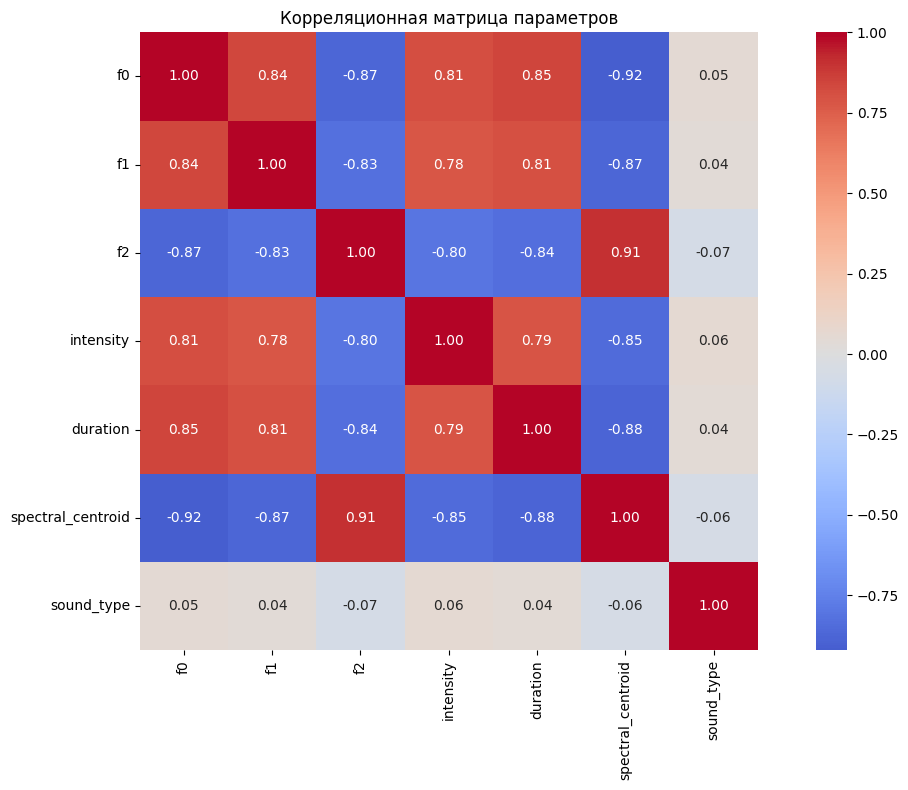

In [16]:
# Основная статистика
print("Статистика параметров по классам:")
print(df.groupby('sound_type_name').describe())

# Корреляционная матрица
plt.figure(figsize=(12, 8))
correlation_matrix = df.drop('sound_type_name', axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f')
plt.title('Корреляционная матрица параметров')
plt.tight_layout()
plt.show()

plt.show()

<h2>Подготовка факторов</h2>

In [17]:
# Разделяем на признаки и целевую переменную
X = df.drop(['sound_type', 'sound_type_name'], axis=1)
y = df['sound_type']

print("Признаки для модели:")
print(X.columns.tolist())

# Разделяем на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nРазмеры выборок:")
print(f"Тренировочная: {X_train.shape}")
print(f"Тестовая: {X_test.shape}")

Признаки для модели:
['f0', 'f1', 'f2', 'intensity', 'duration', 'spectral_centroid']

Размеры выборок:
Тренировочная: (1200, 6)
Тестовая: (300, 6)


<h2>Обучение модели логистической регрессии</h2>

In [18]:
# Создаем pipeline с масштабированием и логистической регрессией
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=42, max_iter=1000))
])

# Обучаем модель
pipeline.fit(X_train, y_train)

# Получаем обученную модель
logreg_model = pipeline.named_steps['logreg']

# Коэффициенты модели
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': logreg_model.coef_[0],
    'abs_coefficient': np.abs(logreg_model.coef_[0]),
    'odds_ratio': np.exp(logreg_model.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print("\nВажность признаков:")
print(feature_importance)


Важность признаков:
             feature  coefficient  abs_coefficient  odds_ratio
2                 f2    -0.166844         0.166844    0.846331
1                 f1    -0.157816         0.157816    0.854007
4           duration    -0.088385         0.088385    0.915408
3          intensity     0.075129         0.075129    1.078023
0                 f0     0.071558         0.071558    1.074180
5  spectral_centroid    -0.027804         0.027804    0.972579


<h2>Оценка качества модели на тестовой выборке и предсказания</h2>

=== РЕЗУЛЬТАТЫ МОДЕЛИ ===
Точность (Accuracy): 0.547
ROC-AUC: 0.588

Отчет по классификации:
              precision    recall  f1-score   support

      сонант       0.54      0.57      0.56       150
     гласный       0.55      0.53      0.54       150

    accuracy                           0.55       300
   macro avg       0.55      0.55      0.55       300
weighted avg       0.55      0.55      0.55       300



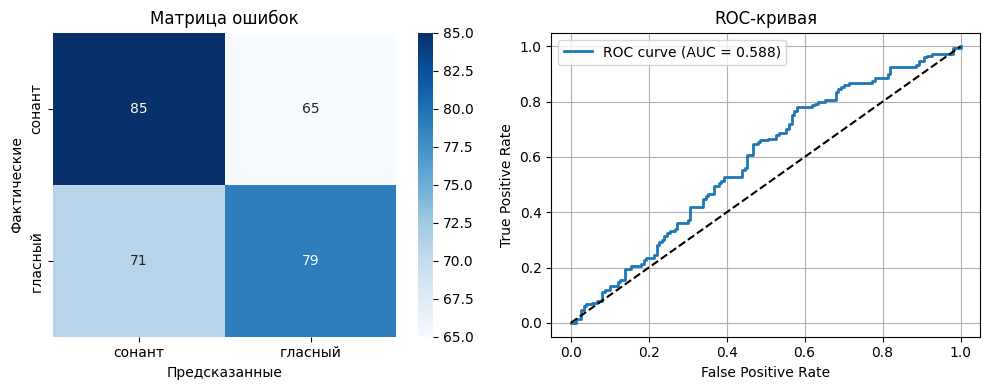

In [19]:
# Предсказания на тестовой выборке
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # Вероятность класса "гласный"

# Метрики качества
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("=== РЕЗУЛЬТАТЫ МОДЕЛИ ===")
print(f"Точность (Accuracy): {accuracy:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")

print("\nОтчет по классификации:")
print(classification_report(y_test, y_pred, target_names=['сонант', 'гласный']))

# Матрица ошибок
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['сонант', 'гласный'],
            yticklabels=['сонант', 'гласный'])
plt.title('Матрица ошибок')
plt.xlabel('Предсказанные')
plt.ylabel('Фактические')

# ROC-кривая
from sklearn.metrics import roc_curve

plt.subplot(1, 2, 2)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, linewidth=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')  # Диагональ случайного классификатора
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

<h2>Практическое применение обученной модели</h2>

In [20]:
def classify_sound(f0, f1, f2, intensity, duration, spectral_centroid):
    """
    Классификация звука на гласный/сонант на основе параметров
    """
    new_data = pd.DataFrame({
        'f0': [f0],
        'f1': [f1],
        'f2': [f2],
        'intensity': [intensity],
        'duration': [duration],
        'spectral_centroid': [spectral_centroid]
    })
    
    # Предсказываем класс и вероятность
    predicted_class = pipeline.predict(new_data)[0]
    predicted_proba = pipeline.predict_proba(new_data)
    
    proba_array = predicted_proba[0] if len(predicted_proba) > 0 else [0.5, 0.5]
    consonant_prob = proba_array[0]
    vowel_prob = proba_array[1]
    
    sound_type = "гласный" if predicted_class == 1 else "сонант"
    confidence = vowel_prob if predicted_class == 1 else consonant_prob
    
    return sound_type, confidence, [consonant_prob, vowel_prob]

print("=== ПРИМЕРЫ КЛАССИФИКАЦИИ ===")

sound1, conf1, proba1 = classify_sound(
    f0=220, f1=700, f2=1200, intensity=78,
    duration=130, spectral_centroid=750
)
print(f"Пример 1: {sound1} (уверенность: {conf1:.3f})")
print(f"Вероятности: [сонант: {proba1[0]:.3f}, гласный: {proba1[1]:.3f}]")

sound2, conf2, proba2 = classify_sound(
    f0=300, f1=350, f2=2000, intensity=62,
    duration=70, 
    spectral_centroid=1500
)
print(f"Пример 2: {sound2} (уверенность: {conf2:.3f})")
print(f"Вероятности: [сонант: {proba2[0]:.3f}, гласный: {proba2[1]:.3f}]")

sound3, conf3, proba3 = classify_sound(
    f0=250, f1=450, f2=1600, intensity=70,
    duration=90, spectral_centroid=1000
)
print(f"Пример 3: {sound3} (уверенность: {conf3:.3f})")
print(f"Вероятности: [сонант: {proba3[0]:.3f}, гласный: {proba3[1]:.3f}]")

=== ПРИМЕРЫ КЛАССИФИКАЦИИ ===
Пример 1: гласный (уверенность: 0.536)
Вероятности: [сонант: 0.464, гласный: 0.536]
Пример 2: гласный (уверенность: 0.557)
Вероятности: [сонант: 0.443, гласный: 0.557]
Пример 3: гласный (уверенность: 0.560)
Вероятности: [сонант: 0.440, гласный: 0.560]


<h2>Анализ порога классификации</h2>

In [21]:
# Анализ влияния порога классификации
thresholds = np.arange(0.1, 1.0, 0.1)

print("\n=== АНАЛИЗ ПОРОГОВ КЛАССИФИКАЦИИ ===")
for threshold in thresholds:
    y_pred_custom = (y_pred_proba >= threshold).astype(int)
    accuracy_custom = accuracy_score(y_test, y_pred_custom)
    print(f"Порог: {threshold:.1f} | Точность: {accuracy_custom:.3f}")


=== АНАЛИЗ ПОРОГОВ КЛАССИФИКАЦИИ ===
Порог: 0.1 | Точность: 0.500
Порог: 0.2 | Точность: 0.500
Порог: 0.3 | Точность: 0.500
Порог: 0.4 | Точность: 0.500
Порог: 0.5 | Точность: 0.547
Порог: 0.6 | Точность: 0.497
Порог: 0.7 | Точность: 0.500
Порог: 0.8 | Точность: 0.500
Порог: 0.9 | Точность: 0.500
